# Fraud Detection with Precision-Oriented Logistic Regression
This notebook builds a fraud detection model on imbalanced credit data. The focus is on maximizing precision — minimizing false positives is our top priority to avoid flagging legitimate transactions.

1. Load and Inspect Dataset
We begin by loading the dataset and briefly inspecting its structure. The data includes demographic and financial features for credit applicants, along with a binary fraud label (TARGET)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    precision_score
)

2. Preprocess Data

* Remove irrelevant columns (Unnamed: 0, ID) from the feature set.

*  Store the original DataFrame separately to retain IDs for final output.

*  Encode categorical columns using LabelEncoder to convert strings to numerical values.

In [2]:
df = pd.read_csv('/content/credit_dataset.csv')

In [3]:
df_original = df.copy()

In [4]:
ids = df['ID']

In [5]:
df.drop(columns=['Unnamed: 0', 'ID'], inplace=True)

In [6]:
categorical_cols = df.select_dtypes(include='object').columns
df_encoded = df.copy()

for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df[col])

3. Split and Scale Data

* Perform a stratified train-test split to maintain class distribution.

*  Apply StandardScaler to normalize the features.

* Keep track of the IDs for test samples to reference later.



In [7]:
X = df_encoded.drop('TARGET', axis=1)
y = df_encoded['TARGET']

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    X_scaled, y, ids, test_size=0.2, stratify=y, random_state=42
)

 4. Train Logistic Regression

* We train a logistic regression model with class_weight='balanced' to deal with the heavy class imbalance in fraud detection.

* This ensures minority class (fraud) samples are given appropriate importance during training.

In [10]:
model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

In [11]:
y_probs = model.predict_proba(X_test)[:, 1]

In [12]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

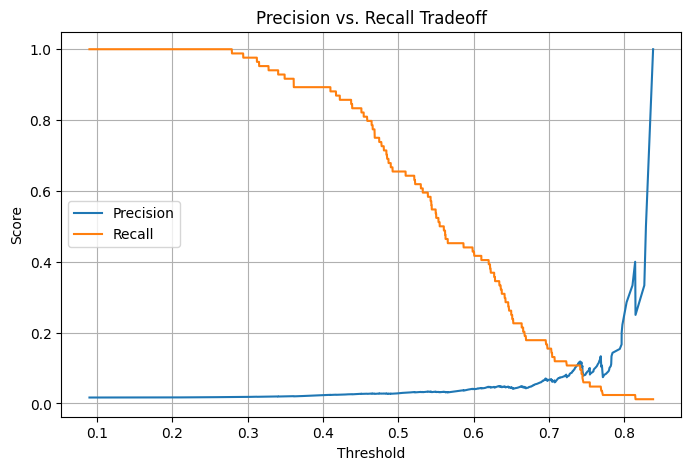

In [13]:
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision vs. Recall Tradeoff')
plt.legend()
plt.grid(True)
plt.show()

5. Predict and Optimize for Precision

  **Instead of using the default 0.5 threshold:**

* We apply a precision-prioritized threshold (e.g., 0.838).

* This threshold ensures that when we flag a transaction as fraud, it is very likely to actually be fraud.

In [14]:
desired_precision = 0.90
optimal_threshold = thresholds[np.argmax(precisions[:-1] >= desired_precision)]

print(f"Chosen threshold for precision >= {desired_precision}: {optimal_threshold:.3f}")

Chosen threshold for precision >= 0.9: 0.838


In [15]:
y_pred = (y_probs >= optimal_threshold).astype(int)

6. Evaluate Model

  **Use classification_report and confusion_matrix to examine:**

* Precision

* Recall

* F1-score

* Number of false positives (important for business cost)

In [19]:
  print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0     0.9835    1.0000    0.9917      4943
           1     1.0000    0.0119    0.0235        84

    accuracy                         0.9835      5027
   macro avg     0.9917    0.5060    0.5076      5027
weighted avg     0.9838    0.9835    0.9755      5027

Confusion Matrix:
 [[4943    0]
 [  83    1]]


7. Display Predicted Fraud Transactions

  **We extract and display the final flagged fraud transactions, showing:**

* Transaction ID

* Model's fraud probability score

* Original feature values

In [16]:
fraud_indices = np.where(y_pred == 1)[0]
predicted_frauds = pd.DataFrame({
    'ID': ids_test.values[fraud_indices],
    'Predicted_Probability': y_probs[fraud_indices]
})

In [17]:
fraud_details = df_original.set_index('ID').loc[predicted_frauds['ID']]
predicted_frauds = predicted_frauds.join(fraud_details, on='ID')

In [18]:
print("Predicted Fraud Transactions:\n")
print(predicted_frauds.reset_index(drop=True))

Predicted Fraud Transactions:

        ID  Predicted_Probability  Unnamed: 0 GENDER CAR REALITY  NO_OF_CHILD  \
0  5096527               0.838434       16336      F   N       N            0   

     INCOME INCOME_TYPE                 EDUCATION_TYPE  ...       HOUSE_TYPE  \
0  135000.0     Working  Secondary / secondary special  ...  Co-op apartment   

  FLAG_MOBIL  WORK_PHONE  PHONE  E_MAIL  FAMILY SIZE  BEGIN_MONTH  AGE  \
0          1           0      0       0          1.0           56   55   

   YEARS_EMPLOYED  TARGET  
0               2       1  

[1 rows x 21 columns]


# Final Summary: Precision-Focused Fraud Detection

**In this project, we tackled fraud detection on an imbalanced dataset using logistic regression.**

Our priority was precision over recall to minimize the cost of false positives (i.e., incorrectly flagging good customers).

I  :

* Cleaned and encoded the data

* Performed stratified splitting and scaling

* Trained a class_weight='balanced' logistic regression model

* Tuned a custom threshold (~0.838) based on precision-recall tradeoff

* **As a result, the model:**

 * Flags only the most confident frauds

 * Minimizes disruption to genuine users